In [11]:
#incijalizacija, ucitavanje mnista preko github linka
from __future__ import print_function

%matplotlib inline

import cv2
import numpy as np
import pandas as pd
import datetime
from sklearn import datasets
from sklearn.datasets.base import get_data_home 


from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN

import collections
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

print (get_data_home())
print("Loading MNIST dataset...")

from six.moves import urllib
from sklearn.datasets import fetch_mldata
from scipy.io import loadmat
from shapely.geometry import LineString, MultiLineString
from shapely.geometry import MultiPoint
from shapely.geometry import Point, Polygon
from shapely.geometry import box


import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# keras

from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D


mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

C:\Users\User\scikit_learn_data
Loading MNIST dataset...
Success!


x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000
Epoch 1/2
60000/60000 [==============================] - 54s 897us/step - loss: 0.5786 - acc: 0.8276
Epoch 2/2
60000/60000 [==============================] - 55s 911us/step - loss: 0.2238 - acc: 0.9335
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
1


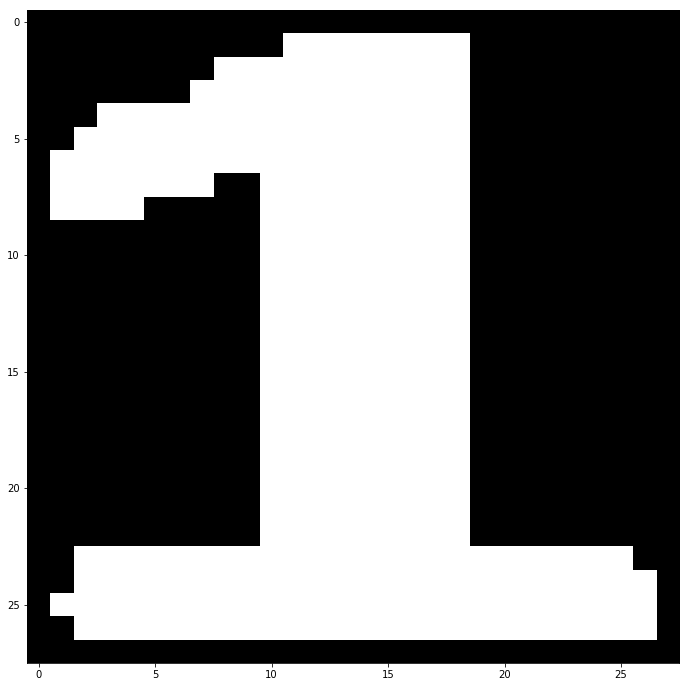

In [38]:
x_train.shape

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])


def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)


def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)


def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_array = []
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y:y+h+1,x:x+w+1]
            regions_array.append([resize_region(region), (x,y,w,h)])       
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    regions_array = sorted(regions_array, key=lambda item: item[1][0])
    sorted_regions = sorted_regions = [region[0] for region in regions_array]
    
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions


def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255


def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()


def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona 
        # region sa skaliranim elementima pretvoriti u vektor
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(scale)
        
    return ready_for_ann


def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)


def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    #ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    #ann.add(Dense(10, activation='sigmoid'))
    ann.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
    ann.add(MaxPooling2D(pool_size=(2, 2)))
    ann.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    ann.add(Dense(128, activation=tf.nn.relu))
    ann.add(Dropout(0.2))
    ann.add(Dense(10,activation=tf.nn.softmax))
    
    return ann
    
def train_ann(ann, x_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
      
    ann.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
    ann.fit(x=x_train,y=y_train, epochs=2)
    
    return ann


image_color = load_image('brojevi.png')

img = invert(image_bin(image_gray(image_color)))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img)
display_image(selected_regions)


# insert alphabet here
alphabet = [0,1,2,3,4,5,6,7,8,9]


inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann,x_train,y_train)


result = ann.predict(np.array(inputs[4].reshape(1, 28, 28, 1), np.float32))
plt.imshow(inputs[1].reshape(28, 28),cmap='Greys')

print(result)
print(result.argmax())

In [39]:
print(datetime.datetime.now().microsecond)

cap = cv2.VideoCapture('video-0.avi')
frames_count, fps, width, height = cap.get(cv2.CAP_PROP_FRAME_COUNT), cap.get(cv2.CAP_PROP_FPS), cap.get(
    cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = int(width)
height = int(height)
#print(frames_count, fps, width, height)

# data frame za frejmove
df = pd.DataFrame(index=range(int(frames_count)))
df.index.name = "Frames"

broj_frejma = 0  # trenutni frejm
total_count = 0
broj_id = []  # id broja
broj_id_presao = []  # prazna lista za dodavanje ID broja koji je presao
broj_id_presao_drugu = []
roi_id = [] # id pracenja regiona interesa
broj_svi = 0  # brojac svih brojeva
region = []
linija_xy = []
prelazna_linija = []
timer = 0
timer2 = 0
# define range of blue and white color in HSV
lower_blue = np.array([110,50,50], dtype=np.uint8)
upper_blue = np.array([130,255,255], dtype=np.uint8)

sensitivity = 30
lower_white = np.array([0,0,255-sensitivity], dtype=np.uint8)
upper_white = np.array([255,sensitivity,255], dtype=np.uint8)

flag = 1;
while True:

    ret, frame = cap.read()  

    if ret:  

        image = frame
        clean_image = frame

        kernel = np.ones((1,4), np.uint8)
        kernel3 = np.ones((3,3),np.uint8)
        kernel1 = np.ones((1,1),np.uint8)

        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask1 = cv2.inRange(hsv, lower_blue, upper_blue)
        mask2 = cv2.inRange(hsv, lower_white, upper_white)
        mask = cv2.bitwise_or(mask1,mask2)
        plava_maska = frame[:,:,0]
        zelena_maska = frame[:,:,1]
        #cv2.imshow('mask',mask2)


        res = cv2.bitwise_and(frame,frame,mask=mask)
        
        plava_maska = cv2.erode(plava_maska,kernel3,iterations = 1)
        zelena_maska = cv2.erode(zelena_maska,kernel3,iterations = 1)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    
        blur = cv2.GaussianBlur(gray,(5,5),0)
        ret, thresh_img = cv2.threshold(blur,127,255,cv2.THRESH_BINARY)               
        im2, contours, hierarchy = cv2.findContours(thresh_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


        #mask2 = cv2.dilate(mask2, kernel,iterations=1)
        #cv2.imshow('mask_dil',mask)
        #cv2.imshow("mask_plava",mask1)


        #dilation = cv2.dilate(mask1, kernel, iterations=1)

        erosion = cv2.erode(mask1, kernel, iterations=1)

       # cv2.imshow("erode",erosion)
        #cv2.imshow("dilate",dilation)

        blur2 = cv2.GaussianBlur(erosion,(5,5),0)
        #cv2.imshow("blur2",blur2)

        minLineLength1 = 40
        maxLineGap2 = 25
        #lines = cv2.HoughLinesP(erosion,1,np.pi/180,100,minLineLength,maxLineGap)     
        #for x1,y1,x2,y2 in lines[0]:
            #cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)




        plava_maska = cv2.dilate(plava_maska,kernel1,iterations = 1)
        zelena_maska = cv2.dilate(zelena_maska,kernel1,iterations = 1)

        #cv2.imshow('blue',plava_maska)

        minLineLength = 300
        maxLineGap = 100

        cannyB = cv2.Canny(plava_maska, threshold1=200, threshold2=300)
        gaussB = cv2.GaussianBlur(cannyB,(7,7),0)
        
        cannyG = cv2.Canny(zelena_maska, threshold1=200, threshold2=300)
        gaussG = cv2.GaussianBlur(cannyG,(7,7),0)
        
        
        while flag:
        
            prelazna_linija = cv2.HoughLinesP(gaussB,1,np.pi/180,100,minLineLength,maxLineGap)
            #print(prelazna_linija)
            for x1,y1,x2,y2 in prelazna_linija[0]:
                cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
           
            prelazna_linija_druga = cv2.HoughLinesP(gaussG,1,np.pi/180,100,minLineLength,maxLineGap)

            #print(prelazna_linija)
            for x1,y1,x2,y2 in prelazna_linija_druga[0]:
                cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
 
            flag = 0

        # line y position created to count contours
        linex = range(286,490)
        liney = range(201,48)


        lineypos2 = 250    
        #linepos = cv2.line(image, (0, lineypos2), (width, lineypos2), (0, 255, 0), 5)
        #linija_tacna = cv2.line(image,(286,201),(490,48),(0,255,0),2)

        rangeVar = len(contours);

        minarea = 20
        maxarea = 200
        cxx = np.zeros(rangeVar)
        cyy = np.zeros(rangeVar)
        
        for i in range(rangeVar):  

            if hierarchy[0, i, 3] == -1:  

                area = cv2.contourArea(contours[i])  

                if minarea < area < maxarea:  

                    cnt = contours[i]
                    M = cv2.moments(cnt)
                    cx = int(M['m10'] / M['m00'])
                    cy = int(M['m01'] / M['m00'])

                    x, y, w, h = cv2.boundingRect(cnt)

                    region = cv2.rectangle(image, (cx-14,cy-14),(cx+14,cy+14),(255,255,255),1)
                    
                    cxx[i] = cx
                    cyy[i] = cy

        cxx = cxx[cxx != 0]
        cyy = cyy[cyy != 0]

        minx_index2 = []
        miny_index2 = []
        maxrad = 1200

        lcxx = len(cxx);
        if lcxx: 

            if not broj_id: 

                for i in range(lcxx):  
                    broj_id.append(i)  
                    df[str(broj_id[i])] = ""  
                    df.at[int(broj_frejma), str(broj_id[i])] = [cxx[i], cyy[i]]
                    broj_svi = broj_id[i] + 1  

            else:  
                dx = np.zeros((lcxx, len(broj_id)))  
                dy = np.zeros((len(cyy), len(broj_id)))  

                for i in range(lcxx):  

                    for j in range(len(broj_id)):  

                        oldcxcy = df.iloc[int(broj_frejma - 1)][str(broj_id[j])]
                        curcxcy = np.array([cxx[i], cyy[i]])
                        if not oldcxcy:  

                            continue 

                        else:  

                            dx[i, j] = oldcxcy[0] - curcxcy[0]
                            dy[i, j] = oldcxcy[1] - curcxcy[1]

                for j in range(len(broj_id)):  

                    sumsum = np.abs(dx[:, j]) + np.abs(dy[:, j])  

                    correctindextrue = np.argmin(np.abs(sumsum))
                    minx_index = correctindextrue
                    miny_index = correctindextrue

                    mindx = dx[minx_index, j]
                    mindy = dy[miny_index, j]

                    if mindx == 0 and mindy == 0 and np.all(dx[:, j] == 0) and np.all(dy[:, j] == 0):

                        continue  

                    else:

                        if np.abs(mindx) < maxrad and np.abs(mindy) < maxrad:

                            df.at[int(broj_frejma), str(broj_id[j])] = [cxx[minx_index], cyy[miny_index]]
                            minx_index2.append(minx_index)  
                            miny_index2.append(miny_index)

                for i in range(lcxx):  

                    if i not in minx_index2 and miny_index2:

                        df[str(broj_svi)] = ""  
                        broj_svi = broj_svi + 1 
                        t = broj_svi - 1 
                        broj_id.append(t)  
                        df.at[int(broj_frejma), str(t)] = [cxx[i], cyy[i]]  

                    elif curcxcy[0] and not oldcxcy and not minx_index2 and not miny_index2:

                        df[str(broj_svi)] = ""  
                        broj_svi += 1  
                        t = broj_svi - 1 
                        broj_id.append(t) 
                        df.at[int(broj_frejma), str(t)] = [cxx[i], cyy[i]]  

        currentnum = 0 
        currentnumindex = []  

        for i in range(len(broj_id)):  

            if df.at[int(broj_frejma), str(broj_id[i])] != '':

                currentnum += 1  
                currentnumindex.append(i)  


        #print(prelazna_linija[0])
        #tacke = prelazna_linija[0]
        #print(tacke)
        #minX = [i[0] for i in tacke]
        #maxX = [i[1] for i in tacke]
        #minY = [i[2] for i in tacke]
        #maxY = [i[3] for i in tacke]
        #xkoord = []

        #for i in range(int(minX[0]),int(maxX[0])):
         #   xkoord.append[i]
         #   print(xkoord)

        #points = MultiPoint([(xm,ym),(xM,yM)])

        for i in range(currentnum): 
            curcent = df.iloc[int(broj_frejma)][str(broj_id[currentnumindex[i]])]
            oldcent = df.iloc[int(broj_frejma - 1)][str(broj_id[currentnumindex[i]])]
            if curcent: 
                if oldcent: 
                    #if oldcent[1] <= lineypos2 and curcent[1] >= lineypos2 and broj_id[                  
                       #currentnumindex[i]] not in broj_id_presao:
                    for x1,y1,x2,y2 in prelazna_linija[0]:
                        xRange = x1,x2,y1,y2

                        xx1 = int(xRange[0]) -10
                        yy1 = int(xRange[1]) -10
                        xx2 = int(xRange[2]) -10
                        yy2 = int(xRange[3]) -10
                        #print(xm, xM, ym, yM)
                        #l1 = Point(xm,yM)
                        #l2 = Point(xM,ym)

                    for gx1,gy1,gx2,gy2 in prelazna_linija_druga[0]:
                        gxRange = gx1,gx2,gy1,gy2

                        gxx1 = int(gxRange[0]) -10
                        gyy1 = int(gxRange[1]) -10
                        gxx2 = int(gxRange[2]) -10
                        gyy2 = int(gxRange[3]) -10
                        endx1 = int(gxRange[0]) +100
                        endy1 = int(gxRange[1]) +100
                        endx2 = int(gxRange[2]) +10
                        endy2 = int(gxRange[3]) +10

                        
                    a1 = int(oldcent[0])
                    a2 = int(oldcent[1])
                    b1 = int(curcent[0])
                    b2 = int(curcent[1])
                    pcentroid = Point(a1,a2)
                    pcentroid2 = Point(b1,b2)
                    p1 = oldcent
                    p2 = curcent
                    poly= box(a1-2,a2-2,a1+2,a2+2)
                    linecent = LineString([p1,p2])
                    #checkbox = box(xm,ym,xM,yM)
                    #linecheck = LineString([(xx1,xx2),(yy1,yy2)])
                    #linecheck_druga = LineString([(gxx1,gxx2),(gyy1,gyy2)])
                    #linecheck_brisanje = LineString([(endx1,endx2),(endy1,endy2)])
                    

                    #print(linecheck, "Drugi", linecent, "\n")

                    linija_tacna = cv2.line(image,(xx1,xx2),(yy1,yy2),(255,255,100),2)
                    linija_tacna_druga = cv2.line(image,(gxx1,gxx2),(gyy1,gyy2),(255,0,100),2)
                    linija_brisanja = cv2.line(image,(endx1,endx2),(endy1,endy2),(255,255,100),2)
                    #linija_druga = cv2.line(image,(xx1,yy1),(xx2,yy2),(0,255,255),2)
                    if poly.intersects(linecheck) and broj_id[                  
                       currentnumindex[i]] not in broj_id_presao:

                        #print("true")
                        cx = int(curcent[0])
                        cy = int(curcent[1])
                        #print(cx,cy)
                        roi = mask2[cy-14:cy+14, cx-14:cx+14]
                        #roi = resize_region(roi)
                        cv2.imshow("roi",roi)
                        kernel2 = np.ones((1,20),np.uint8)
                        roi2 = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)
                        cv2.imshow('close',roi2)

                        scale = roi/255
                        #cv2.imshow("scale",scale)
                        vektor = roi2.flatten()

                        result = ann.predict(np.array(vektor.reshape(1,28,28,1),np.float32))
                        #plt.imshow(vektor.reshape(28, 28),cmap='Greys')
                        print("Prepoznat broj na prvoj liniji: ",result.argmax())
                        vreme = int(datetime.datetime.now().microsecond)
                        threshold = 500
                        razlika1 = vreme-timer
                        if(razlika1 > threshold):
                            total_count = total_count + result.argmax()
                            timer = vreme
                            print("Total count posle sabiranja: ",total_count)

                        #cv2.line(image, (0, lineypos2), (width, lineypos2), (0, 0, 125), 5)
                        #cv2.line(image, (0, lines), (width, lines), (0, 0, 125), 5)
                        broj_id_presao.append(currentnumindex[i])

                    if poly.intersects(linecheck_druga) and broj_id[                  
                       currentnumindex[i]] not in broj_id_presao_drugu:

                        #print("true")
                        cx = int(curcent[0])
                        cy = int(curcent[1])
                        #print(cx,cy)
                        roi = mask2[cy-14:cy+14, cx-14:cx+14]
                        #roi = resize_region(roi)
                        cv2.imshow("roi",roi)
                        kernel2 = np.ones((1,20),np.uint8)
                        roi2 = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)
                        cv2.imshow('close',roi2)

                        scale = roi/255
                        #cv2.imshow("scale",scale)
                        vektor = roi2.flatten()

                        result = ann.predict(np.array(vektor.reshape(1,28,28,1),np.float32))
                        #plt.imshow(vektor.reshape(28, 28),cmap='Greys')
                        vreme2 = int(datetime.datetime.now().microsecond)
                        threshold2 = 500
                        razlika = vreme2-timer2
                        if(razlika > threshold2):
                            total_count = total_count - result.argmax()
                            timer2 = vreme2
                            print("Total count posle oduzimanja: ",total_count)
                        #total_count = total_count - result.argmax()
                        #cv2.line(image, (0, lineypos2), (width, lineypos2), (0, 0, 125), 5)
                        #cv2.line(image, (0, lines), (width, lines), (0, 0, 125), 5)
                        broj_id_presao_drugu.append(currentnumindex[i]) 
                        

                    

        # displays images and transformations
        cv2.imshow("countours", image)

        #cv2.imshow("Result", np.hstack([frame, image]))

        broj_frejma = broj_frejma + 1

        k = cv2.waitKey(int(1000/fps)) & 0xff  # int(1000/fps) is normal speed since waitkey is in ms
        if k == 27:
            break

    else: 
        break
print("Total count",total_count)
cap.release()
cv2.destroyAllWindows()

#for p in range(0, 9):
   # cap = cv2.VideoCapture('video-' + str(p) + '.avi')
    #f = open('result.txt','a+')
    #f.write(str(total_count))
   # f.write("\n")
    #f.close()

65404
Prepoznat broj na prvoj liniji:  7
Total count posle sabiranja:  7
Prepoznat broj na prvoj liniji:  6
Prepoznat broj na prvoj liniji:  6
Total count posle oduzimanja:  4
Prepoznat broj na prvoj liniji:  3
Total count posle sabiranja:  7
Prepoznat broj na prvoj liniji:  3
Total count 7
